Bu bölümde, projemizde kullanacağımız "Car Brand Classification" veri setini yükleyip temel özelliklerini anlamak için keşifsel veri analizi (EDA) yapacağız.

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing
import os

def create_dataframe(base_path):
    if not base_path or not isinstance(base_path, str):
        raise ValueError("Geçerli bir klasör yolu girilmelidir.")
        
    if not os.path.exists(base_path):
        raise FileNotFoundError(f"Klasör bulunamadı: {base_path}")
        
    label = []
    path = []
    try:
        for dir_name, _,filenames in os.walk(base_path):
            for filename in filenames:
                if os.path.splitext(filename)[1]=='.jpg':
                    if dir_name.split()[-1]!='GT':          
                        label.append(os.path.split(dir_name)[1])
                        path.append(os.path.join(dir_name, filename))
            
        df = pd.DataFrame({'path': path, 'label': label})
        df = df.drop_duplicates()
        
        if df.isnull().any().any():
            print("Uyarı: DataFrame'de boş değerler var!")
            
        print("\nEtiket dağılımı:")
        print(df['label'].value_counts())
    
        return df
        
    except Exception as e:
        raise Exception(f"DataFrame oluşturulurken hata oluştu: {str(e)}")

try:
    data = create_dataframe('/kaggle/input/car-brand-classification-dataset/Car Brand Classification Dataset/train')
    print(f"\nToplam görüntü sayısı: {data.shape[0]}")
    print(f"Sütun sayısı: {data.shape[1]}")
except Exception as e:
    print(f"Hata: {str(e)}")


Etiket dağılımı:
label
Nissan           349
Ford             349
Hyundai          349
Mercedes-Benz    349
Chrysler         349
GMC              349
Lincoln          349
FIAT             349
Aston Martin     349
Volkswagen       349
Land Rover       349
Buick            349
Honda            349
Dodge            349
Porsche          349
Kia              349
Toyota           349
Jeep             349
Volvo            349
Mitsubishi       349
Cadillac         349
Chevrolet        349
Jaguar           349
Bentley          349
BMW              349
Lexus            349
Audi             349
INFINITI         349
Acura            349
Subaru           349
Mazda            349
Ram              349
MINI             349
Name: count, dtype: int64

Toplam görüntü sayısı: 11517
Sütun sayısı: 2


Veri setindeki sınıfların (araba markaları) dağılımını ve toplam resim sayısını yukarıda gördük. Her sınıfta eşit sayıda resim olması, modelin dengeli bir şekilde eğitilmesine yardımcı olacaktır. Şimdi `info()` metodu ile oluşturduğumuz DataFrame'in yapısını inceleyelim. Bu, sütun tipleri ve eksik veri olup olmadığı hakkında hızlıca bilgi verir.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11517 entries, 0 to 11516
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    11517 non-null  object
 1   label   11517 non-null  object
dtypes: object(2)
memory usage: 180.1+ KB


Veri setindeki farklı markalara ait bazı görselleri görselleştirme.

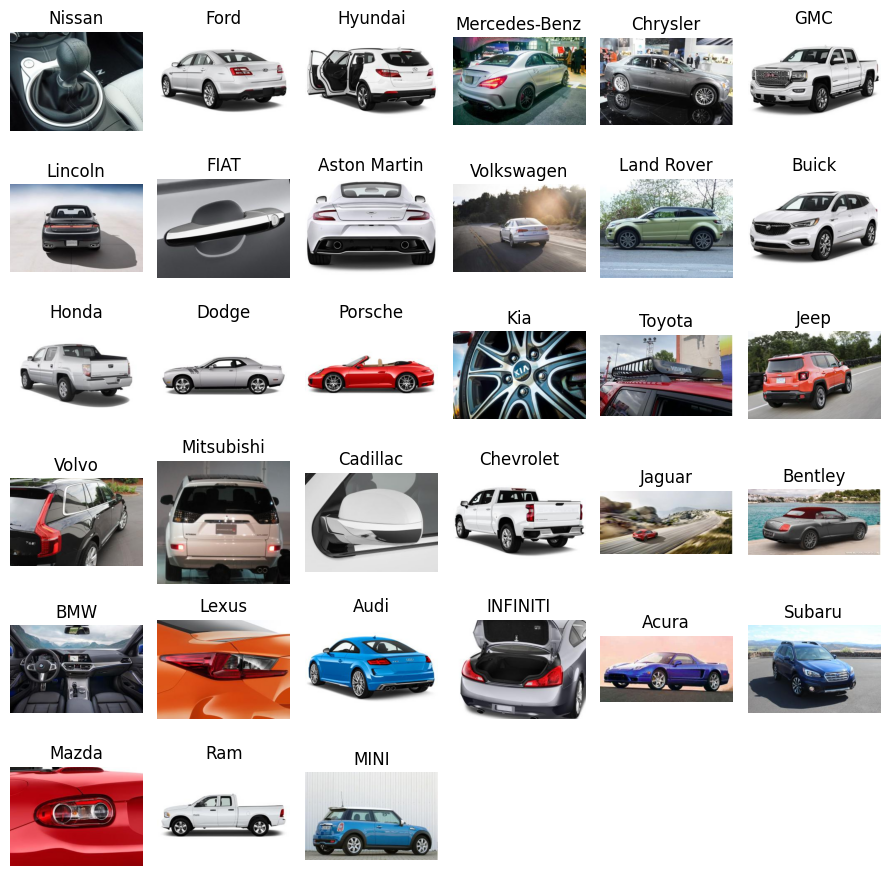

In [4]:
import matplotlib.pyplot as plt
import cv2

unique_labels = data['label'].unique()
plt.figure(figsize=(9, 9))

for i, label in enumerate(unique_labels[:]):
    sample = data[data['label'] == label].sample(1).iloc[0]
    img_path = sample['path']
    
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 

    plt.subplot(6, 6, i+1)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

plt.tight_layout()
plt.show()

Modelimizi eğitmeye başlamadan önce veriyi hazırlamamız gerekiyor. Bu adım iki temel amaç taşır:
1.  Normalizasyon: Resimlerin piksel değerlerini (0-255 aralığındadır) 0 ile 1 arasına ölçekleyerek modelin daha stabil ve hızlı öğrenmesini sağlarız.
2.  Veri Artırma (Data Augmentation): Mevcut resimler üzerinden küçük değişiklikler (döndürme, kaydırma, zoom yapma vb.) yaparak yeni ve benzersiz veri örnekleri oluştururuz. Bu, modelin ezber yapmasını (overfitting) engeller ve daha önce görmediği resimler üzerinde daha başarılı olmasını sağlar.

Bu işlemleri `ImageDataGenerator` kullanarak kolayca yapacağız ve veriyi eğitim (training) ve doğrulama (validation) olarak ikiye ayıracağız.

In [5]:
import numpy as np
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

def prepare_data(df, img_size=(128, 128)):
    """
    Görüntüleri tensorflow.keras.preprocessing.image kullanarak yükler ve modele hazır hale getirir
    """
    X = []
    y = []
    
    # LabelEncoder'ı oluştur
    label_encoder = LabelEncoder()
    
    # Etiketleri sayısal değerlere dönüştür
    df['label'] = label_encoder.fit_transform(df['label'])
    
    for idx, row in df.iterrows():
        # Görüntüyü yükle
        img = image.load_img(row['path'], 
                             target_size=img_size,
                             color_mode='rgb')
        
        # Görüntüyü array'e çevir
        img_array = image.img_to_array(img)
        
        # Normalize et (0-1 arasına)
        img_array = img_array / 255.0
        
        X.append(img_array)
        y.append(row['label'])
    
    y = to_categorical(y, num_classes=len(label_encoder.classes_))
    
    return np.array(X), np.array(y), label_encoder

# Veriyi hazırla
X, y, label_encoder = prepare_data(data)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Test-Train verisi hazırlandı.")

Test-Train verisi hazırlandı.


In [6]:
from tensorflow.keras import backend as K

K.clear_session()



Bu görev için, sıfırdan bir model eğitmek yerine Transfer Öğrenme (Transfer Learning) tekniğini kullanacağız. Bu teknikte, ImageNet gibi çok büyük bir veri setinde önceden eğitilmiş başarılı bir modelin (bu örnekte VGG16) "öğrendiği" bilgiyi kendi problemimize aktarırız.


1.  Temel Model (Base Model): VGG16 modelini, sonundaki sınıflandırma katmanları olmadan yüklüyoruz. Bu modelin temel katmanları, resimlerden kenar, doku, şekil gibi genel özellikleri tanımayı zaten öğrenmiştir.
2.  Katmanları Dondurma: VGG16'nın orijinal ağırlıklarının eğitim sırasında bozulmaması için bu katmanları "donduruyoruz" (`trainable = False`).
3.  Yeni Katmanlar Ekleme: Modelin sonuna kendi sınıflandırıcımızı ekliyoruz. `Flatten` katmanı ile özellik haritalarını tek boyutlu bir vektöre çevirip, `Dense` katmanları ile kendi sınıflarımızı (araba markaları) öğrenmesini sağlıyoruz.

In [7]:

from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

def create_transfer_model(num_classes):
    """
    VGG16 tabanlı bir transfer öğrenmesi modeli.
    """
    # VGG16 modelini, son sınıflandırma katmanları olmadan yüklüyoruz.
    # weights='imagenet' -> Milyonlarca resimle öğrenilmiş ağırlıkları kullanır.
    base_model = VGG16(weights='imagenet', 
                       include_top=False, 
                       input_shape=(128, 128, 3))

    # VGG16'nın mevcut ağırlıklarının eğitim sırasında bozulmaması için katmanları donduruyoruz.
    base_model.trainable = False

    model = Sequential([
        base_model,
        Flatten(),
        Dense(256, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

num_classes = y_train.shape[1]  # Sınıf sayısını y_train'den alıyoruz (33)
model = create_transfer_model(num_classes)

I0000 00:00:1758897973.046092      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 33)             │         8,481 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,820,577 (64.17 MB)

 Trainable params: 2,105,889 (8.03 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Modelimizi oluşturup derledikten sonra, sıra eğitim aşamasına geldi. `model.fit()` fonksiyonu ile `ImageDataGenerator` aracılığıyla hazırladığımız eğitim verilerini modele besleyeceğiz. Model, her bir veri bloğunu (batch) işledikten sonra tahminlerinin ne kadar hatalı olduğunu hesaplayacak ve bu hatayı azaltmak için kendi ağırlıklarını güncelleyecektir. Bu işlem, belirlediğimiz epoch sayısı kadar tekrarlanacaktır.

Doğrulama verileri (`validation_data`) ise modelin her epoch sonunda eğitimde görmediği veriler üzerindeki performansını ölçmek için kullanılır. Bu sayede modelin ezber yapıp yapmadığını takip edebiliriz.

In [8]:
from tensorflow.keras.callbacks import EarlyStopping

# Erken durdurma uygulama
early_stopping = EarlyStopping(monitor='val_loss', patience=9, restore_best_weights=True)

# Modeli eğitme
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=100,
                    batch_size=32,
                    callbacks=[early_stopping])



Epoch 1/100


I0000 00:00:1758897988.629339     107 service.cc:148] XLA service 0x7a542000d9a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758897988.630059     107 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1758897988.981957     107 cuda_dnn.cc:529] Loaded cuDNN version 90300


  7/288 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.0634 - loss: 3.9886

I0000 00:00:1758897993.020887     107 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


288/288 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.0523 - loss: 3.5566 - val_accuracy: 0.0907 - val_loss: 3.3282
Epoch 2/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.1261 - loss: 3.1828 - val_accuracy: 0.1697 - val_loss: 3.0814
Epoch 3/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.2082 - loss: 2.8561 - val_accuracy: 0.1979 - val_loss: 2.9630
Epoch 4/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.2814 - loss: 2.5885 - val_accuracy: 0.2153 - val_loss: 2.9151
Epoch 5/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.3482 - loss: 2.3298 - val_accuracy: 0.2422 - val_loss: 2.9256
Epoch 6/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.4156 - loss: 2.0864 - val_accuracy: 0.2426 - val_loss: 2.8821
Epoch 7/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.4879 - loss: 1.8608 - val_accuracy: 0.2834 - val_loss: 2.8108
Epoch 8/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.5480 - loss: 1.6470 - val_

Modelimizi eğittik, şimdi eğitim sürecinin ne kadar başarılı geçtiğini değerlendirelim. Aşağıdaki grafikler, modelin eğitim ve doğrulama setleri üzerindeki doğruluk (accuracy) ve kayıp (loss) değerlerinin epoch'lar boyunca nasıl değiştiğini gösterecek.

Doğruluk Grafiği: Eğitim ve doğrulama doğruluğunun birlikte artması ideal durumdur. Eğer eğitim doğruluğu artarken doğrulama doğruluğu düşmeye başlarsa, bu modelin ezber yapmaya (overfitting) başladığının bir işaretidir.

Kayıp Grafiği: Hem eğitim hem de doğrulama kaybının düşmesi beklenir. Eğitim kaybı düşerken doğrulama kaybının artması da yine ezberleme belirtisidir.

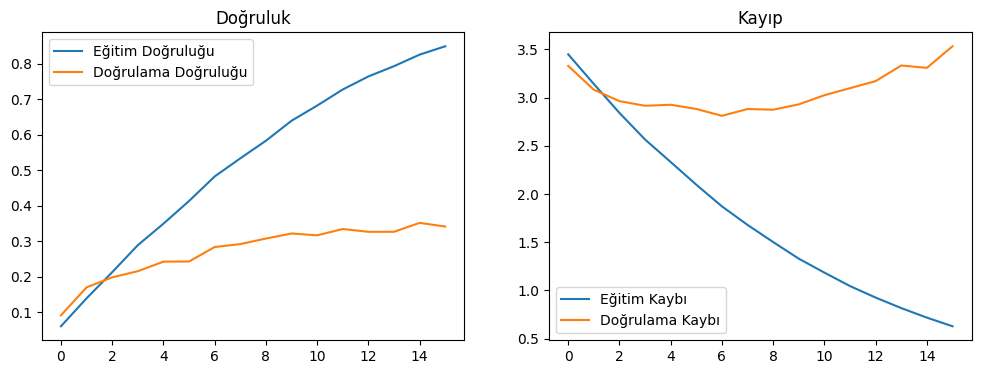

In [9]:
def visualize_metrics(history):
    
    # Eğitim sürecini görselleştirelim
    plt.figure(figsize=(12, 4))

    # Doğruluk
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
    plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
    plt.title('Doğruluk')
    plt.legend()

    # Kayıp
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Eğitim Kaybı')
    plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
    plt.title('Kayıp')
    plt.legend()

    plt.show()
    
visualize_metrics(history)

72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step


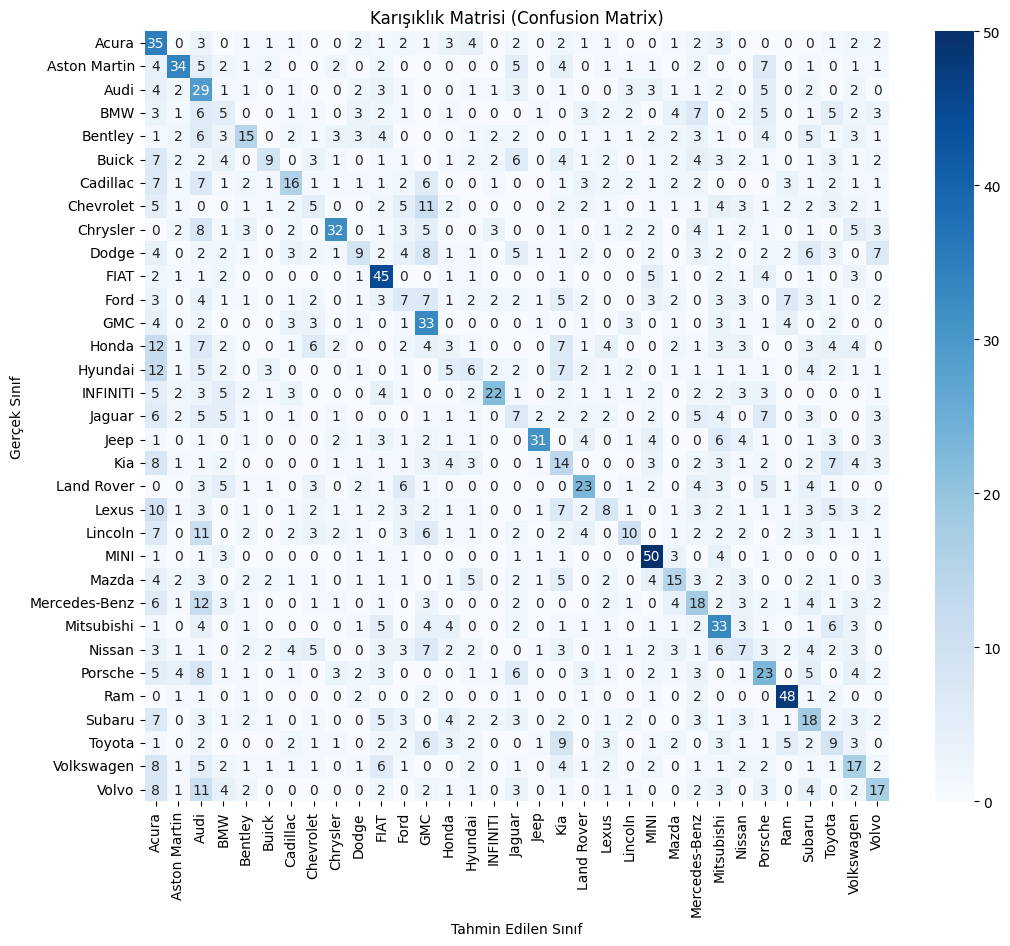

Sınıflandırma Raporu:
                precision    recall  f1-score   support

        Acura       0.19      0.49      0.27        71
 Aston Martin       0.52      0.45      0.48        76
         Audi       0.18      0.42      0.25        69
          BMW       0.09      0.08      0.08        61
      Bentley       0.32      0.21      0.26        70
        Buick       0.36      0.13      0.19        68
     Cadillac       0.33      0.23      0.27        69
    Chevrolet       0.12      0.08      0.10        61
     Chrysler       0.59      0.39      0.47        83
        Dodge       0.24      0.12      0.16        76
         FIAT       0.42      0.62      0.50        72
         Ford       0.12      0.10      0.11        69
          GMC       0.29      0.52      0.37        64
        Honda       0.07      0.04      0.05        73
      Hyundai       0.14      0.09      0.11        65
     INFINITI       0.58      0.32      0.41        69
       Jaguar       0.12      0.11      0

In [10]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1) 
y_true = np.argmax(y_test, axis=1)
class_names = label_encoder.classes_
cm = confusion_matrix(y_true, y_pred_classes)

# Matrisi görselleştir
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Karışıklık Matrisi (Confusion Matrix)')
plt.xlabel('Tahmin Edilen Sınıf')
plt.ylabel('Gerçek Sınıf')
plt.xticks(rotation=90) # x-ekseni etiketlerini dikey yapalım
plt.yticks(rotation=0)  # y-ekseni etiketleri yatay kalsın
plt.show()

# Sınıflandırma Raporunu oluştur ve yazdır
report = classification_report(y_true, y_pred_classes, target_names=class_names)
print("Sınıflandırma Raporu:\n", report)

In [11]:
import tensorflow as tf
from tensorflow import keras
from keras_tuner import Hyperband
import numpy as np

# Hiperparametre optimizasyonu için model oluşturma fonksiyonu (Daha küçük sınırlar ile)
def build_model(hp):
    model = keras.Sequential()
    
    model.add(keras.layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=32, max_value=96, step=32), 
        kernel_size=hp.Choice('conv_1_kernel', values=[3, 5]),
        activation='relu',
        input_shape=(128, 128, 3)
    ))
    model.add(keras.layers.MaxPooling2D((2, 2)))

    for i in range(hp.Int('num_conv_layers', 1, 2)): 
        model.add(keras.layers.Conv2D(
            filters=hp.Int(f'conv_{i+2}_filter', min_value=32, max_value=128, step=32), 
            kernel_size=hp.Choice(f'conv_{i+2}_kernel', values=[3, 5]),
            activation='relu'
        ))
        model.add(keras.layers.MaxPooling2D((2, 2)))

    model.add(keras.layers.Flatten())
    
    model.add(keras.layers.Dense(
        units=hp.Int('dense_units', min_value=128, max_value=256, step=64), 
        activation='relu'
    ))
    model.add(keras.layers.Dropout(
        hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)
    ))

    model.add(keras.layers.Dense(33, activation='softmax'))
    
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Hyperband tuner'ını kuralım
tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=30,
    factor=3,
    directory='hyperparam_tuning_dir',
    project_name='araba_markasi_cnn'
)

# Erken durdurma callback'i
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# En iyi hiperparametreleri bulmak için aramayı başlat
print("Hiperparametre optimizasyonu (daha dar aralıkla) başlıyor...")
tuner.search(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=16,
    callbacks=[early_stopping]
)

# En iyi hiperparametreleri al ve modeli oluştur
print("\nEn iyi hiperparametreler bulundu:")
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)
model.summary()

Trial 90 Complete [00h 01m 07s]
val_accuracy: 0.3155381977558136

Best val_accuracy So Far: 0.3324652910232544
Total elapsed time: 00h 55m 15s

En iyi hiperparametreler bulundu:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 124, 124, 96)   │         7,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 62, 62, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 58, 58, 128)    │       307,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 29, 29, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 107648)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 192)            │    20,668,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 33)             │         6,369 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,989,601 (80.07 MB)

 Trainable params: 20,989,601 (80.07 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# En iyi ayarların ne olduğunu görmek için ekrana yazdıralım
print("\nBulunan En İyi Hiperparametreler:")
print(f"Conv 1 Filtre: {best_hps.get('conv_1_filter')}")
print(f"Conv 1 Kernel: {best_hps.get('conv_1_kernel')}")
print(f"Dense Nöron Sayısı: {best_hps.get('dense_units')}")
print(f"Dropout Oranı: {best_hps.get('dropout')}")
print(f"Öğrenme Oranı: {best_hps.get('learning_rate')}")


print("\nBu en iyi ayarlarla yeni bir model oluşturuluyor...")
best_model = tuner.hypermodel.build(best_hps)

print("\nEn iyi modeliniz oluşturuldu. Özeti aşağıdadır:")
best_model.summary()


Bulunan En İyi Hiperparametreler:
Conv 1 Filtre: 96
Conv 1 Kernel: 5
Dense Nöron Sayısı: 192
Dropout Oranı: 0.4
Öğrenme Oranı: 0.00012715537157600873

Bu en iyi ayarlarla yeni bir model oluşturuluyor...

En iyi modeliniz oluşturuldu. Özeti aşağıdadır:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 124, 124, 96)   │         7,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 62, 62, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 58, 58, 128)    │       307,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 29, 29, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 107648)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 192)            │    20,668,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 33)             │         6,369 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,989,601 (80.07 MB)

 Trainable params: 20,989,601 (80.07 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Veri artırma için generator'ı burada tanımlıyoruz
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Generator'ı eğitim verisine uygula
datagen.fit(X_train)

print("datagen nesnesi oluşturuldu ve eğitime hazır.")

datagen nesnesi oluşturuldu ve eğitime hazır.


In [14]:
print("En iyi modelin eğitimi başlıyor...")

# En iyi modeli, veri artırma (data augmentation) ile eğitiyoruz.
# EarlyStopping callback'ini yine kullanıyoruz ki en uygun noktada dursun.
history = best_model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    steps_per_epoch=len(X_train) // 32,
    validation_data=(X_test, y_test),
    epochs=100, # EarlyStopping en iyi epoch sayısını kendi bulacaktır
    callbacks=[early_stopping] # Daha önce tanımladığımız early_stopping
)

print("\nEn iyi modelin eğitimi tamamlandı!")

En iyi modelin eğitimi başlıyor...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100


2025-09-26 15:49:09.952416: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[128,96,5,5]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,96,62,62]{3,2,1,0}, f32[32,128,58,58]{3,2,1,0}), window={size=5x5}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-09-26 15:49:10.220399: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.268110606s
Trying algorithm eng0{} for conv (f32[128,96,5,5]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,96,62,62]{3,2,1,0}, f32[32,128,58,58]{3,2,1,0}), window={size=5x5}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_

 72/287 ━━━━━━━━━━━━━━━━━━━━ 23s 108ms/step - accuracy: 0.0251 - loss: 3.5357

2025-09-26 15:49:22.151865: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[128,96,5,5]{3,2,1,0}, u8[0]{0}) custom-call(f32[29,96,62,62]{3,2,1,0}, f32[29,128,58,58]{3,2,1,0}), window={size=5x5}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-09-26 15:49:22.302114: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.150366274s
Trying algorithm eng0{} for conv (f32[128,96,5,5]{3,2,1,0}, u8[0]{0}) custom-call(f32[29,96,62,62]{3,2,1,0}, f32[29,128,58,58]{3,2,1,0}), window={size=5x5}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_

287/287 ━━━━━━━━━━━━━━━━━━━━ 44s 131ms/step - accuracy: 0.0293 - loss: 3.5104 - val_accuracy: 0.0382 - val_loss: 3.4885
Epoch 2/100
  1/287 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.0625 - loss: 3.4987

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0625 - loss: 3.4987 - val_accuracy: 0.0382 - val_loss: 3.4884
Epoch 3/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 32s 111ms/step - accuracy: 0.0429 - loss: 3.4866 - val_accuracy: 0.0460 - val_loss: 3.4678
Epoch 4/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0312 - loss: 3.4948 - val_accuracy: 0.0460 - val_loss: 3.4677
Epoch 5/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 32s 110ms/step - accuracy: 0.0485 - loss: 3.4686 - val_accuracy: 0.0608 - val_loss: 3.4528
Epoch 6/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0312 - loss: 3.4632 - val_accuracy: 0.0599 - val_loss: 3.4531
Epoch 7/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 32s 110ms/step - accuracy: 0.0519 - loss: 3.4624 - val_accuracy: 0.0621 - val_loss: 3.4318
Epoch 8/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0625 - loss: 3.5580 - val_accuracy: 0.0595 - val_loss: 3.4310
Epoch 9/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 32s 110ms/step - accuracy: 0.0577 - loss: 3.4469 - val_accu